In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(0.1, 1, 100)
num = np.sin(5*np.pi*X)
y = num/(5*np.pi*X)
Y = y

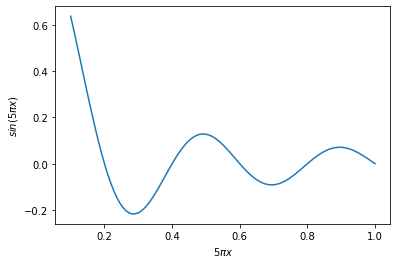

In [3]:
plt.plot(X,Y)
plt.xlabel(r'$5\pi x$')
plt.ylabel(r'$sin(5\pi x)$')
plt.show()

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

X_t = torch.tensor(X, dtype = torch.float32)
y_t = torch.tensor(Y, dtype = torch.float32)
X_t = X_t.view(X_t.shape[0], 1)
y_t = y_t.view(y_t.shape[0], 1)

In [5]:
class func_simulator1(nn.Module):
    def __init__(self):
        super(func_simulator1, self).__init__()
        self.l1 = nn.Linear(1, 5)
        self.l2 = nn.Linear(5, 30)
        self.l3 = nn.Linear(30, 50)
        self.l4 = nn.Linear(50, 30)
        self.l5 = nn.Linear(30, 10)
        self.l6 = nn.Linear(10, 5)
        self.l7 = nn.Linear(5, 1)


    def forward(self, x):
        out = F.tanh(self.l1(x))
        out = F.tanh(self.l2(out))
        out = F.tanh(self.l3(out))
        out = F.tanh(self.l4(out))
        out = F.tanh(self.l5(out))
        out = F.tanh(self.l6(out))
        out = F.tanh(self.l7(out)) 
        return out

class func_simulator2(nn.Module):
    def __init__(self):
        super(func_simulator2, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l2 = nn.Linear(10, 30)
        self.l3 = nn.Linear(30, 10)
        self.l4 = nn.Linear(10, 1)

    def forward(self, x):
        out = F.tanh(self.l1(x))
        out = F.tanh(self.l2(out))
        out = F.tanh(self.l3(out))
        out = F.tanh(self.l4(out))
        return out

class func_simulator3(nn.Module):
    def __init__(self):
        super(func_simulator3, self).__init__()
        self.l1 = nn.Linear(1, 128)
        self.l2 = nn.Linear(128, 1)
        # self.l3 = nn.Linear(128, 30)
        # self.l4 = nn.Linear(30, 10)
        # self.l5 = nn.Linear(10, 1)

    def forward(self, x):
        out = F.tanh(self.l1(x))
        out = F.tanh(self.l2(out))
        # out = F.tanh(self.l3(out))
        # out = F.tanh(self.l4(out))
        # out = F.tanh(self.l5(out))
        return out
    
class func_simulator4(nn.Module):
    def __init__(self,):
        super(func_simulator4, self).__init__()
        self.linear1 = nn.Linear(1, 5)
        self.linear2 = nn.Linear(5, 10)
        self.linear3 = nn.Linear(10, 10)
        self.linear4 = nn.Linear(10, 10)
        self.linear5 = nn.Linear(10, 10)
        self.linear6 = nn.Linear(10, 10)
        self.linear7 = nn.Linear(10, 5)
        self.predict = nn.Linear(5, 1)
    
    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear1(x))
        x = nn.functional.leaky_relu(self.linear2(x))
        x = nn.functional.leaky_relu(self.linear3(x))
        x = nn.functional.leaky_relu(self.linear4(x))
        x = nn.functional.leaky_relu(self.linear5(x))
        x = nn.functional.leaky_relu(self.linear6(x))
        x = nn.functional.leaky_relu(self.linear7(x))

        x = self.predict(x)
        return x

In [6]:
# train on batch
def train_model_old(model, learning_rate, num_epochs):
    losses = []
    gradient                = torch.optim.SGD(model.parameters(),lr=learning_rate)
    grad_array = []
    for epoch in range(num_epochs):
        y_pred = model.forward(X_t)
        l = loss(y_pred,y_t)
        
        if(epoch+1)%1000==0:
#            print(f'epoch:{epoch+1},loss={l.item():.2e}')
            losses.append((epoch+1, l.item()))
        l.backward()
        # if epoch >= 35000:
        #     lr = 0.5*learning_rate
        gradient.step()
        gradient.zero_grad()
        
    y_bar = model(X_t).detach().numpy()
    return y_bar, np.array(losses)


In [7]:
def train_model(model, X_t, y_t, Me):
    max_epoch = Me
    epoch_arr, loss_arr = [], []
    not_converged = True
    epoch = 0
    grad_arr = []
#    gradient                = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
    while not_converged:
        epoch +=1
        y_pred = model.forward(X_t)
        l = loss(y_pred, y_t)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()  
        epoch_arr.append(epoch)
        loss_arr.append(l.item())
        
        grad_all = 0.0
        for param in model.parameters():
            grad = 0.0
            if param.grad is not None:
                grad = (param.grad.cpu().data.numpy()**2).sum()
                grad_all += grad
                
        grad_norm = grad_all ** 0.5
        
        grad_arr.append(grad_norm)
        
        if epoch % 100 == 0:
            print(f'epoch: {epoch}, loss = {l.item():.3f}')
            print(f'gradient: {grad_norm:.4f}')
        if epoch == max_epoch:
            print('Max Epoch Reached')
            not_converged = False
            
        elif (epoch > 5) and (loss_arr[-1] > 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-10 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-10:
                print("Convergence reached for loss:", loss_arr[-1])
                not_converged = False
    return epoch_arr, loss_arr, y_pred, grad_arr
                     

In [8]:
learning_rate,num_epochs    = 0.01,5000
model1                      = func_simulator1()
model2                      = func_simulator2()
model3                      = func_simulator3()
model4                      = func_simulator4()
loss                        = nn.MSELoss()

In [9]:
model = model1
Me = 1000

In [10]:
Total_params = sum(p.numel() for p in model.parameters()) 
print('Total_params for model 1 : ', Total_params)

Total_params for model 1 :  3641


In [11]:
# Y1, L1 = train_model(model1, learning_rate, num_epochs)
# Y2, L2 = train_model(model2, 0.1, num_epochs) 
# Y3, L3 = train_model(model3, learning_rate, num_epochs) 
Epoch_arr, Loss_arr, Prediction, Grad_arr = train_model(model, X_t, y_t, Me)
Epoch_arr1, Loss_arr1, Prediction1, Grad_arr1 = train_model(model4, X_t, y_t, Me)

/Users/mengkel/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 100, loss = 0.023
gradient: 0.0090
epoch: 200, loss = 0.019
gradient: 0.0112
epoch: 300, loss = 0.006
gradient: 0.0159
epoch: 400, loss = 0.004
gradient: 0.0040
epoch: 500, loss = 0.004
gradient: 0.0040
epoch: 600, loss = 0.003
gradient: 0.0034
epoch: 700, loss = 0.003
gradient: 0.0030
epoch: 800, loss = 0.003
gradient: 0.0027
epoch: 900, loss = 0.003
gradient: 0.0025
epoch: 1000, loss = 0.003
gradient: 0.0024
Max Epoch Reached
epoch: 100, loss = 0.024
gradient: 0.0121
epoch: 200, loss = 0.024
gradient: 0.0006
epoch: 300, loss = 0.024
gradient: 0.0005
epoch: 400, loss = 0.024
gradient: 0.0005
epoch: 500, loss = 0.024
gradient: 0.0005
epoch: 600, loss = 0.024
gradient: 0.0010
epoch: 700, loss = 0.023
gradient: 0.0051
epoch: 800, loss = 0.018
gradient: 0.0165
epoch: 900, loss = 0.007
gradient: 0.0092
epoch: 1000, loss = 0.006
gradient: 0.0009
Max Epoch Reached


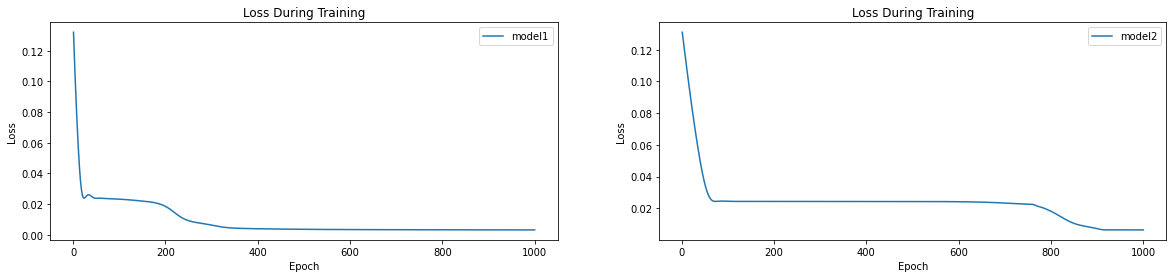

In [12]:
fig = plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(Epoch_arr, Loss_arr, label = 'model1')
plt.title('Loss During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epoch_arr1, Loss_arr1, label = 'model2')
plt.title('Loss During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

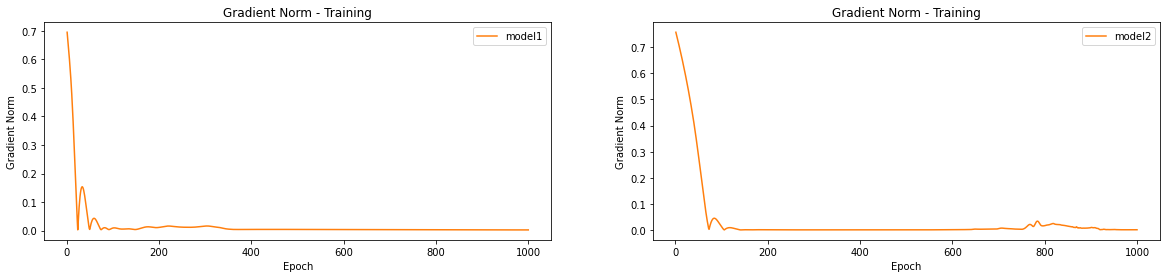

In [13]:
fig = plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(Epoch_arr, Grad_arr, label = 'model1', color = '#ff7f0e')
plt.title('Gradient Norm - Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epoch_arr1, Grad_arr1, label = 'model2', color = '#ff7f0e')
plt.title('Gradient Norm - Training')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.show()